In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import joblib

from catboost import CatBoostClassifier
from xgboost import XGBClassifier


In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("weatherAUS.csv")
pd.set_option("display.max_columns", None)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [4]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 16
Discrete feature Count 2
Continuous feature Count 14
Categorical feature Count 7


In [5]:
# Handle Missing Values
df.isnull().sum()*100/len(df)

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

In [6]:
print(numerical_feature)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


Random Sample Imputation

Random sample imputation consists of taking random observation from the dataset and we use these random observations to replace the NaN values. This method assumes that the data are missing completely at random (MCAR).

In [7]:
def randomsampleimputation(df, variable):
    df[variable]=df[variable]
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable]=random_sample

In [8]:
randomsampleimputation(df, "Cloud9am")
randomsampleimputation(df, "Cloud3pm")
randomsampleimputation(df, "Evaporation")
randomsampleimputation(df, "Sunshine")

In [9]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,2.4,8.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,1.4,7.8,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,7.6,13.5,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,6.8,11.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,2.6,13.2,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


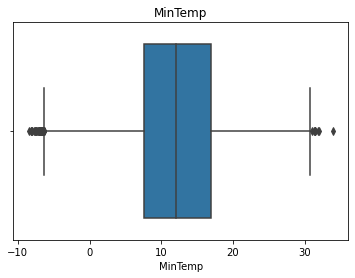

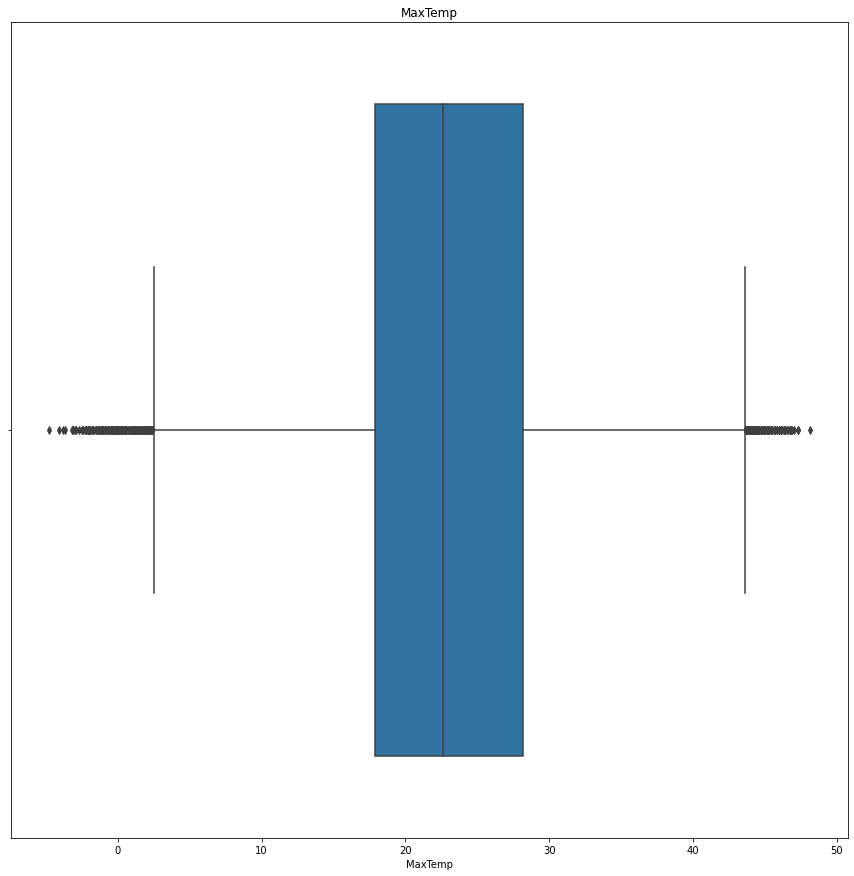

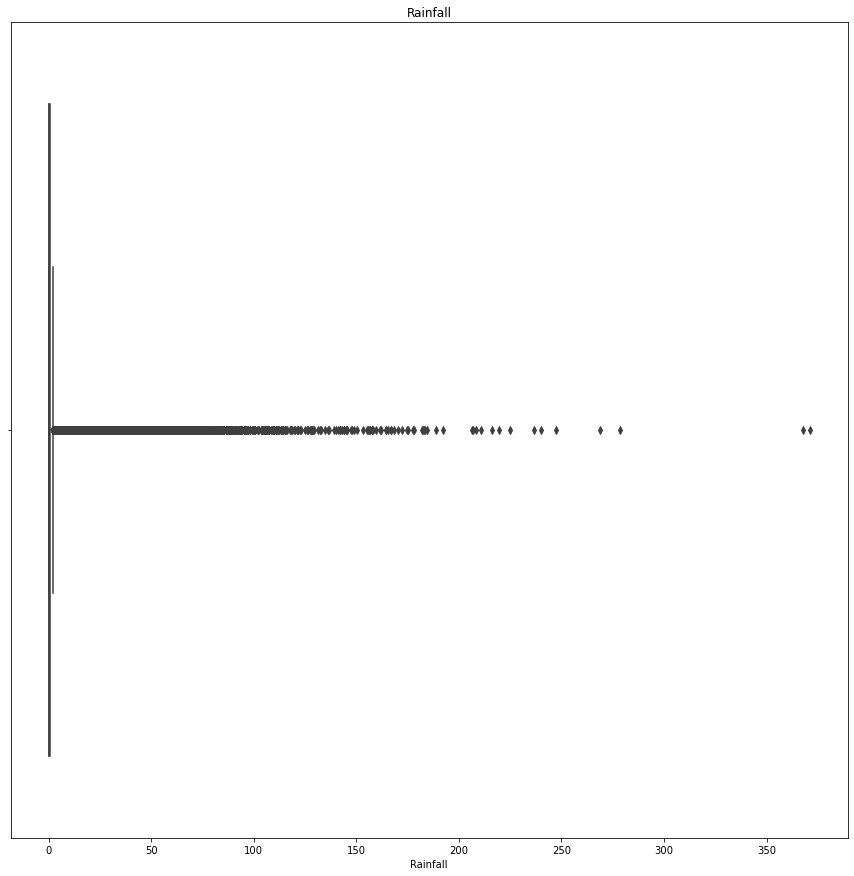

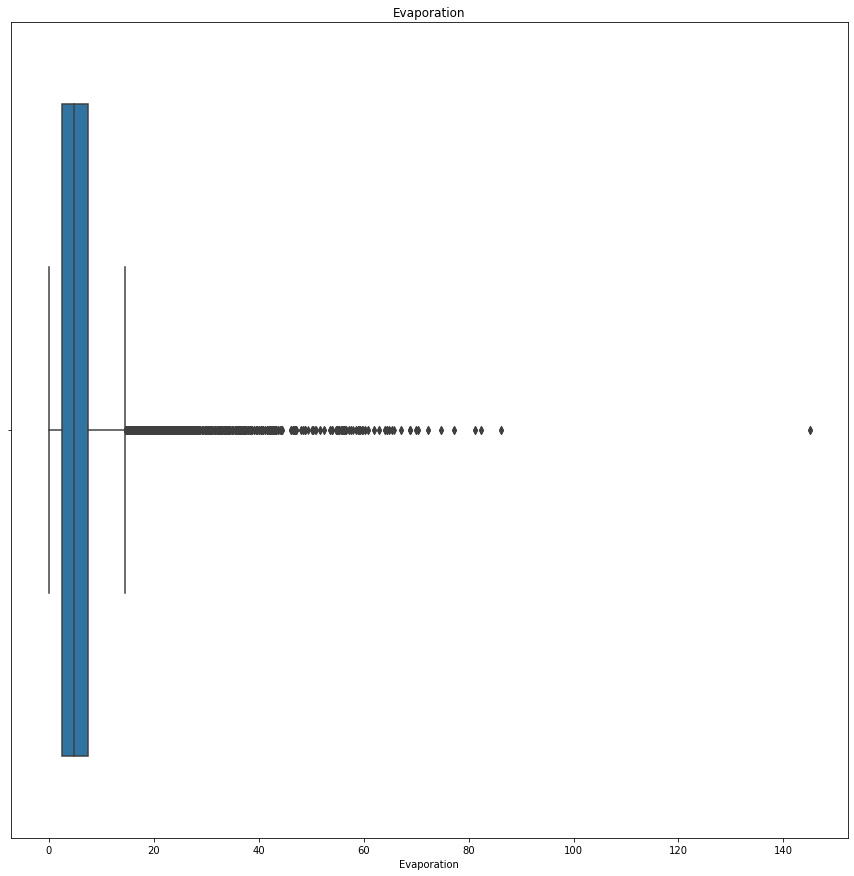

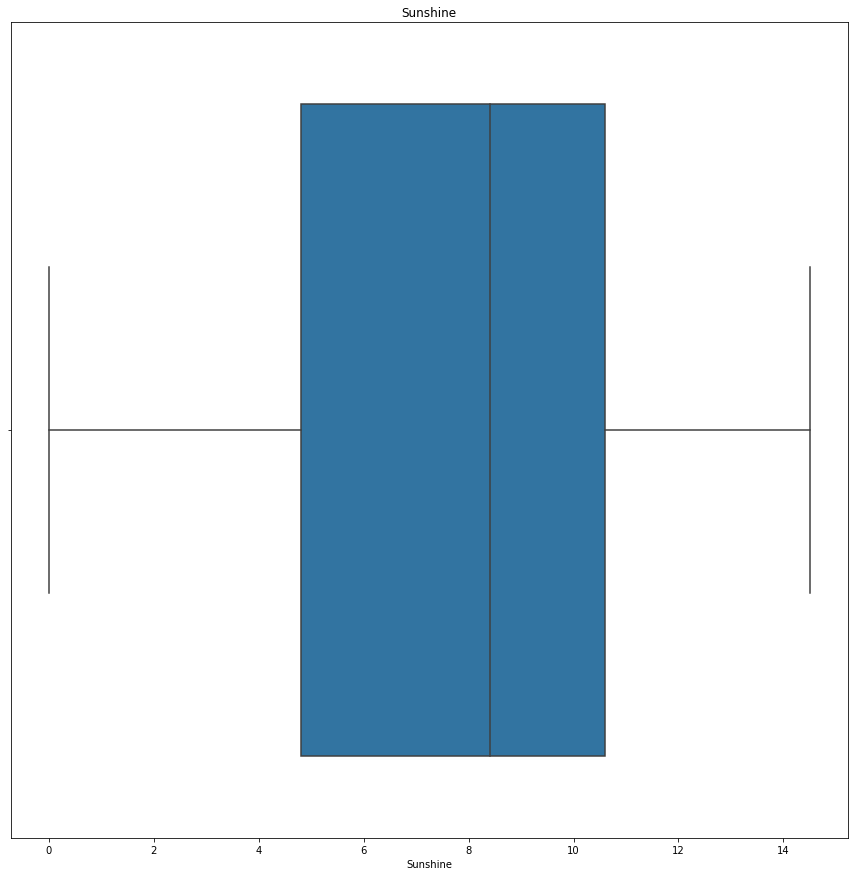

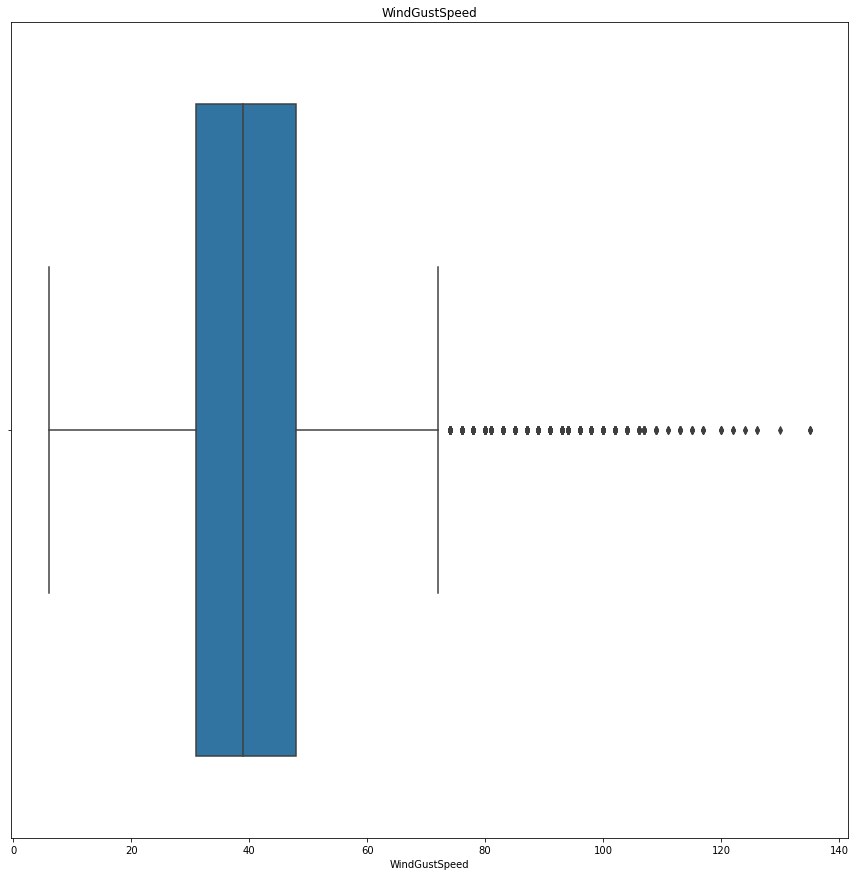

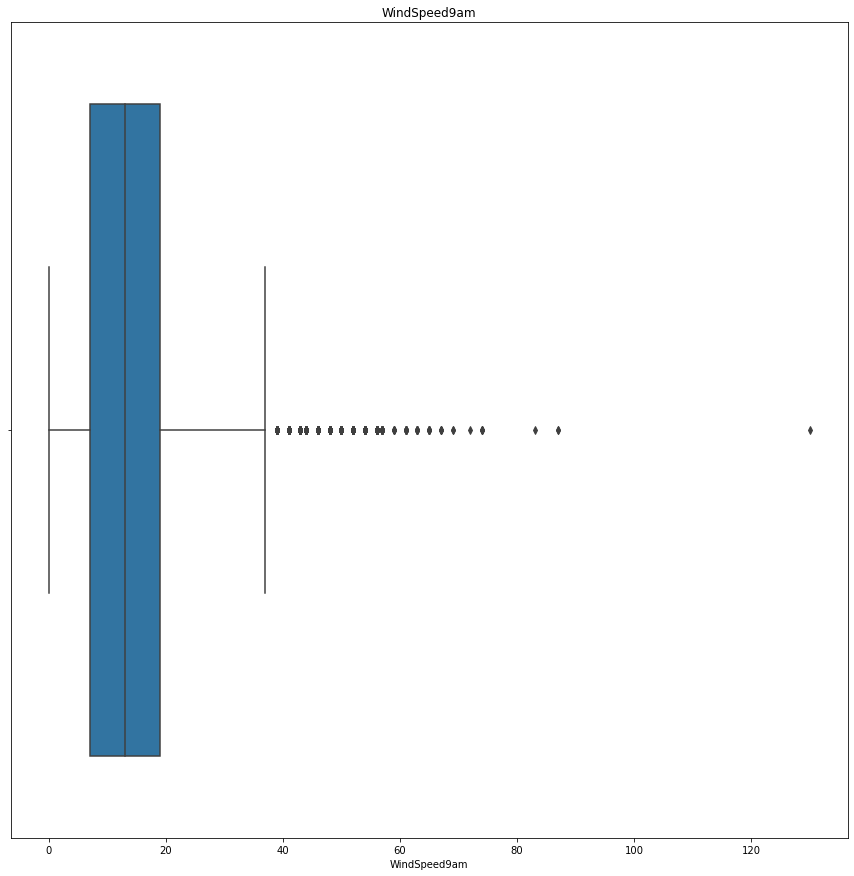

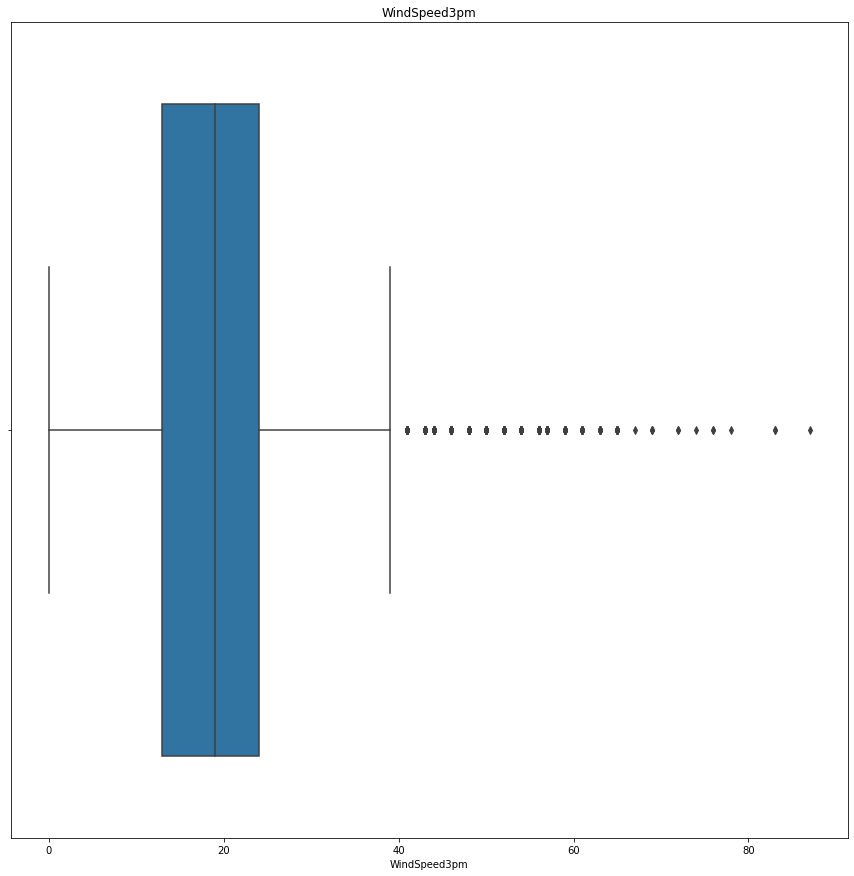

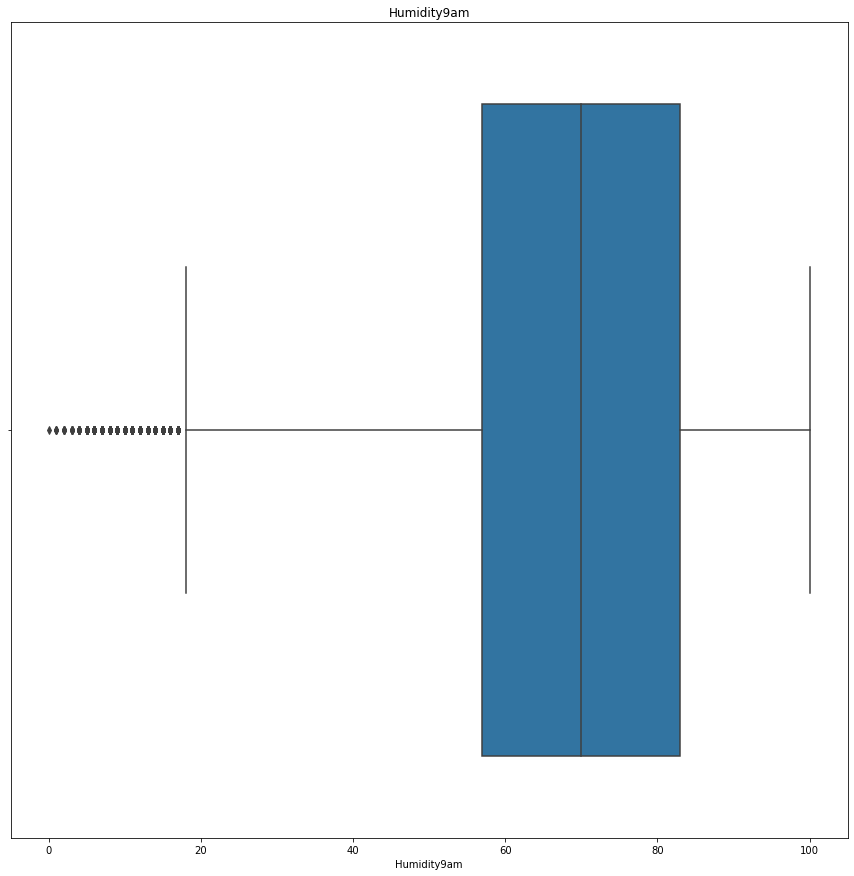

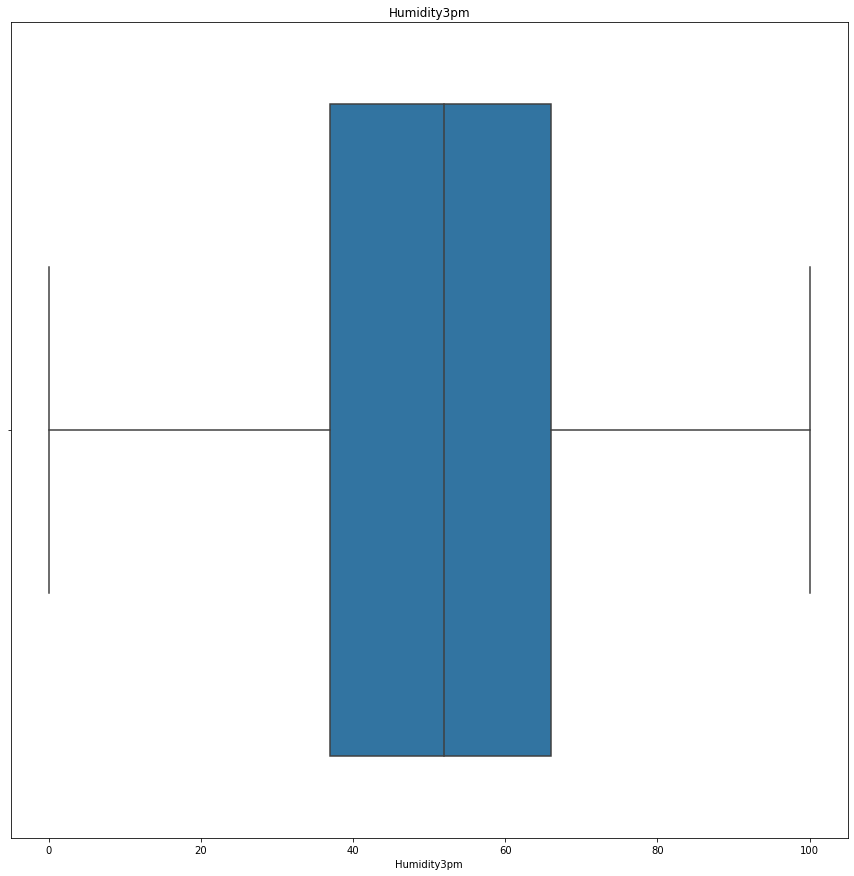

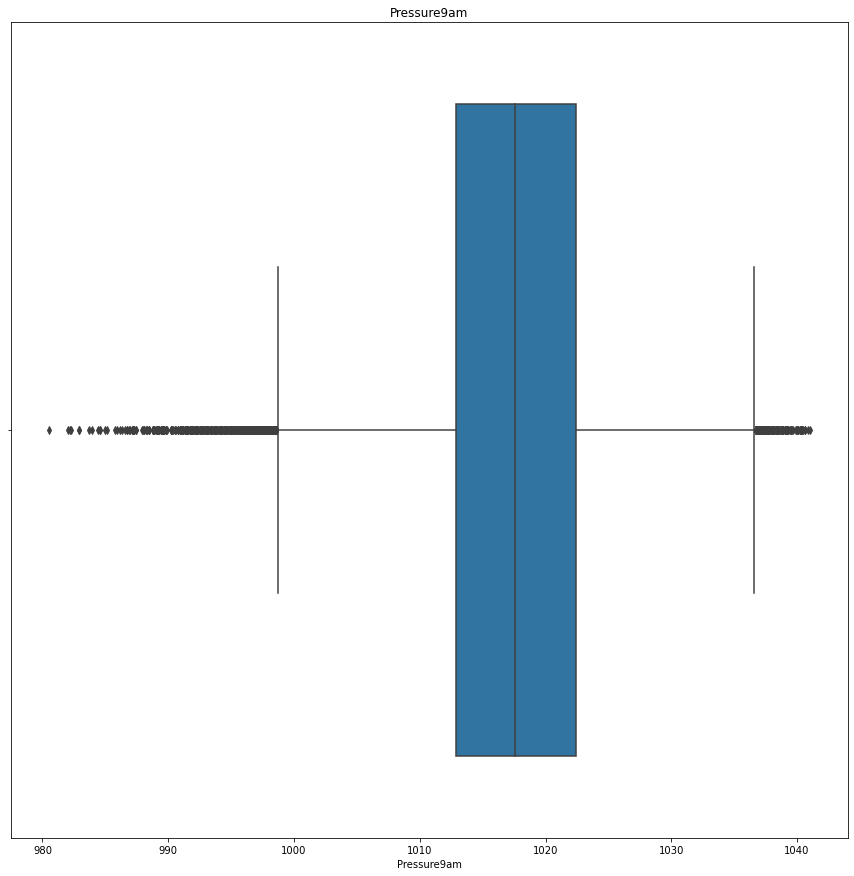

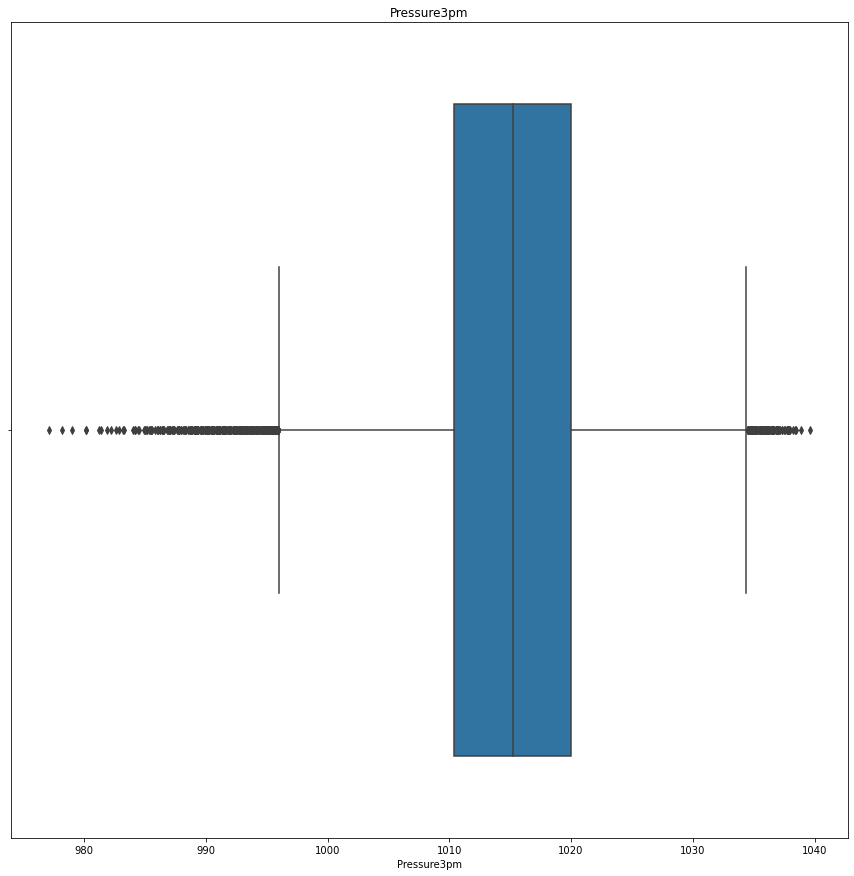

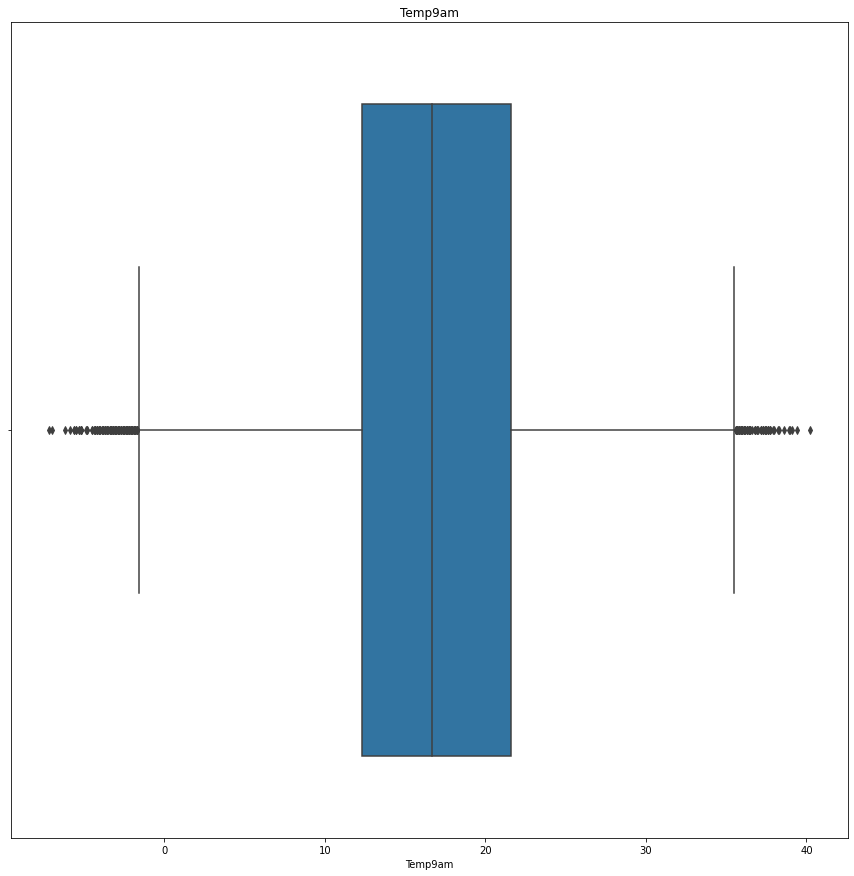

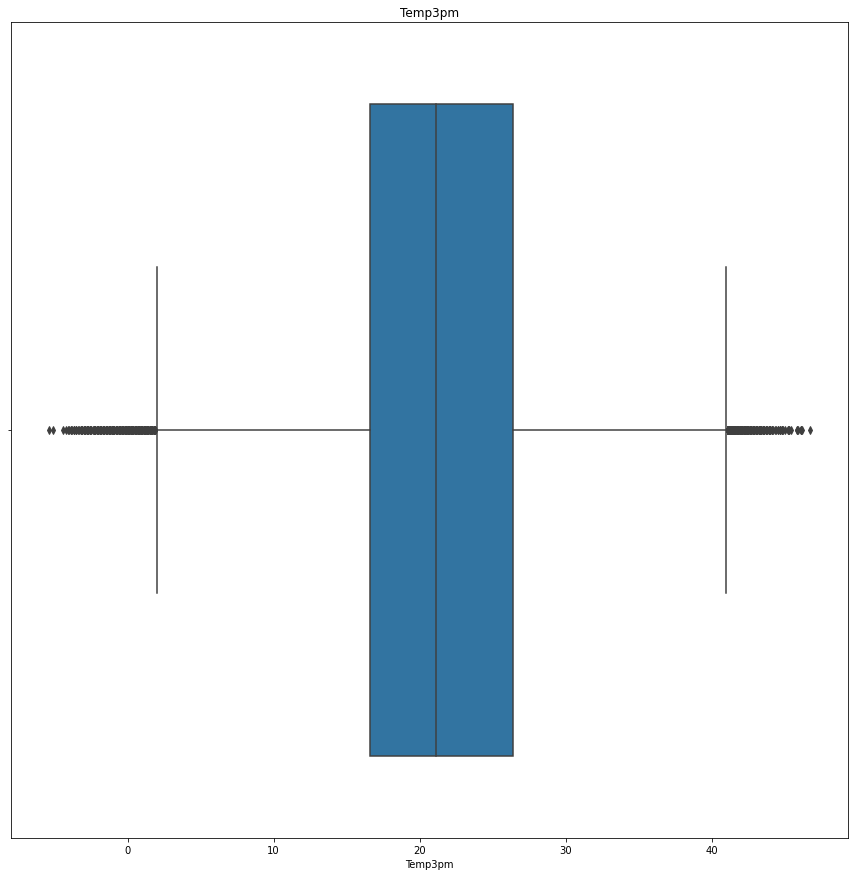

<Figure size 1080x1080 with 0 Axes>

In [10]:
#A for loop is used to plot a boxplot for all the continuous features to see the outliers
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In R randomForest package there is na.roughfix option : A completed data matrix or data frame. For numeric variables, NAs are replaced with column medians. For factor variables, NAs are replaced with the most frequent levels (breaking ties at random). If object contains no NAs, it is returned unaltered.

In [11]:
for feature in continuous_feature:
    if(df[feature].isnull().sum()*100/len(df))>0:
        df[feature] = df[feature].fillna(df[feature].median())

In [12]:
df.isnull().sum()*100/len(df)

Date             0.000000
Location         0.000000
MinTemp          0.000000
MaxTemp          0.000000
Rainfall         0.000000
Evaporation      0.000000
Sunshine         0.000000
WindGustDir      7.098859
WindGustSpeed    0.000000
WindDir9am       7.263853
WindDir3pm       2.906641
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
Humidity9am      0.000000
Humidity3pm      0.000000
Pressure9am      0.000000
Pressure3pm      0.000000
Cloud9am         0.000000
Cloud3pm         0.000000
Temp9am          0.000000
Temp3pm          0.000000
RainToday        2.241853
RainTomorrow     2.245978
dtype: float64

In [13]:
discrete_feature

['Cloud9am', 'Cloud3pm']

value_counts() function returns object containing counts of unique values

In [14]:
def mode_nan(df,variable):
    mode=df[variable].value_counts().index[0]
    df[variable].fillna(mode,inplace=True)
mode_nan(df,"Cloud9am")
mode_nan(df,"Cloud3pm")

One Hot Label Encoding : find unique values 

In [15]:
df["RainToday"] = pd.get_dummies(df["RainToday"], drop_first = True)
df["RainTomorrow"] = pd.get_dummies(df["RainTomorrow"], drop_first = True)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,2.4,8.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0
1,2008-12-02,Albury,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0
2,2008-12-03,Albury,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0
3,2008-12-04,Albury,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0
4,2008-12-05,Albury,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,1.4,7.8,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0
145456,2017-06-22,Uluru,3.6,25.3,0.0,7.6,13.5,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0
145457,2017-06-23,Uluru,5.4,26.9,0.0,6.8,11.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0
145458,2017-06-24,Uluru,7.8,27.0,0.0,2.6,13.2,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0


Sort by descending

In [16]:
for feature in categorical_feature:
    print(feature, (df.groupby([feature])["RainTomorrow"].mean().sort_values(ascending = False)).index)

Date Index(['2007-11-01', '2007-12-15', '2008-02-03', '2008-01-31', '2008-01-30',
       '2008-01-19', '2008-01-18', '2008-01-16', '2008-01-12', '2007-11-30',
       ...
       '2008-05-08', '2008-05-09', '2008-01-03', '2008-01-02', '2008-05-10',
       '2008-05-11', '2008-05-12', '2008-05-13', '2008-05-14', '2007-12-25'],
      dtype='object', name='Date', length=3436)
Location Index(['Portland', 'Walpole', 'Cairns', 'Dartmoor', 'NorfolkIsland',
       'MountGambier', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'MountGinini',
       'NorahHead', 'Darwin', 'Sydney', 'SydneyAirport', 'Ballarat',
       'GoldCoast', 'Watsonia', 'Newcastle', 'Hobart', 'Wollongong',
       'Williamtown', 'Launceston', 'Brisbane', 'MelbourneAirport', 'Adelaide',
       'Sale', 'Albury', 'Perth', 'Melbourne', 'Nuriootpa', 'Penrith',
       'BadgerysCreek', 'PerthAirport', 'Tuggeranong', 'Richmond', 'Bendigo',
       'Canberra', 'WaggaWagga', 'Townsville', 'Katherine', 'PearceRAAF',
       'SalmonGums', 'Nhil', 

Labeling the categorical value in order

In [17]:
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
       'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
       'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
       'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}
df["WindGustDir"] = df["WindGustDir"].map(windgustdir)
df["WindDir9am"] = df["WindDir9am"].map(winddir9am)
df["WindDir3pm"] = df["WindDir3pm"].map(winddir3pm)

In [18]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0
1,2008-12-02,Albury,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0
2,2008-12-03,Albury,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0
3,2008-12-04,Albury,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0
4,2008-12-05,Albury,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0
145456,2017-06-22,Uluru,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0
145457,2017-06-23,Uluru,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0
145458,2017-06-24,Uluru,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0


In [19]:
df["WindGustDir"] = df["WindGustDir"].fillna(df["WindGustDir"].value_counts().index[0])
df["WindDir9am"] = df["WindDir9am"].fillna(df["WindDir9am"].value_counts().index[0])
df["WindDir3pm"] = df["WindDir3pm"].fillna(df["WindDir3pm"].value_counts().index[0])

In [20]:
df.isnull().sum()*100/len(df)

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

In [21]:
df1 = df.groupby(["Location"])["RainTomorrow"].value_counts().sort_values().unstack()

By doing unstack we are transforming the last level of the index to the columns. All the RainTomorrow values will now be the columns of a the dataframe and when a entry has not have a certain RainTomorrow value this feature will get Nan value. 

In [22]:
df1

RainTomorrow,0,1
Location,,
Adelaide,2505,688
Albany,2138,902
Albury,2422,618
AliceSprings,2796,244
BadgerysCreek,2426,583
Ballarat,2259,781
Bendigo,2478,562
Brisbane,2484,709
Cairns,2090,950


Labelling the location values

In [23]:
location = {'Portland':1, 'Cairns':2, 'Walpole':3, 'Dartmoor':4, 'MountGambier':5,
       'NorfolkIsland':6, 'Albany':7, 'Witchcliffe':8, 'CoffsHarbour':9, 'Sydney':10,
       'Darwin':11, 'MountGinini':12, 'NorahHead':13, 'Ballarat':14, 'GoldCoast':15,
       'SydneyAirport':16, 'Hobart':17, 'Watsonia':18, 'Newcastle':19, 'Wollongong':20,
       'Brisbane':21, 'Williamtown':22, 'Launceston':23, 'Adelaide':24, 'MelbourneAirport':25,
       'Perth':26, 'Sale':27, 'Melbourne':28, 'Canberra':29, 'Albury':30, 'Penrith':31,
       'Nuriootpa':32, 'BadgerysCreek':33, 'Tuggeranong':34, 'PerthAirport':35, 'Bendigo':36,
       'Richmond':37, 'WaggaWagga':38, 'Townsville':39, 'PearceRAAF':40, 'SalmonGums':41,
       'Moree':42, 'Cobar':43, 'Mildura':44, 'Katherine':45, 'AliceSprings':46, 'Nhil':47,
       'Woomera':48, 'Uluru':49}
df["Location"] = df["Location"].map(location)

In [24]:
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%dT", errors = "coerce")

In [25]:
df["Date_month"] = df["Date"].dt.month
df["Date_day"] = df["Date"].dt.day

Adding moth and day as colmns in table

In [26]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,12,1
1,2008-12-02,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,12,2
2,2008-12-03,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,12,3
3,2008-12-04,30,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,12,4
4,2008-12-05,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,49,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0,6,21
145456,2017-06-22,49,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0,6,22
145457,2017-06-23,49,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0,6,23
145458,2017-06-24,49,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,6,24


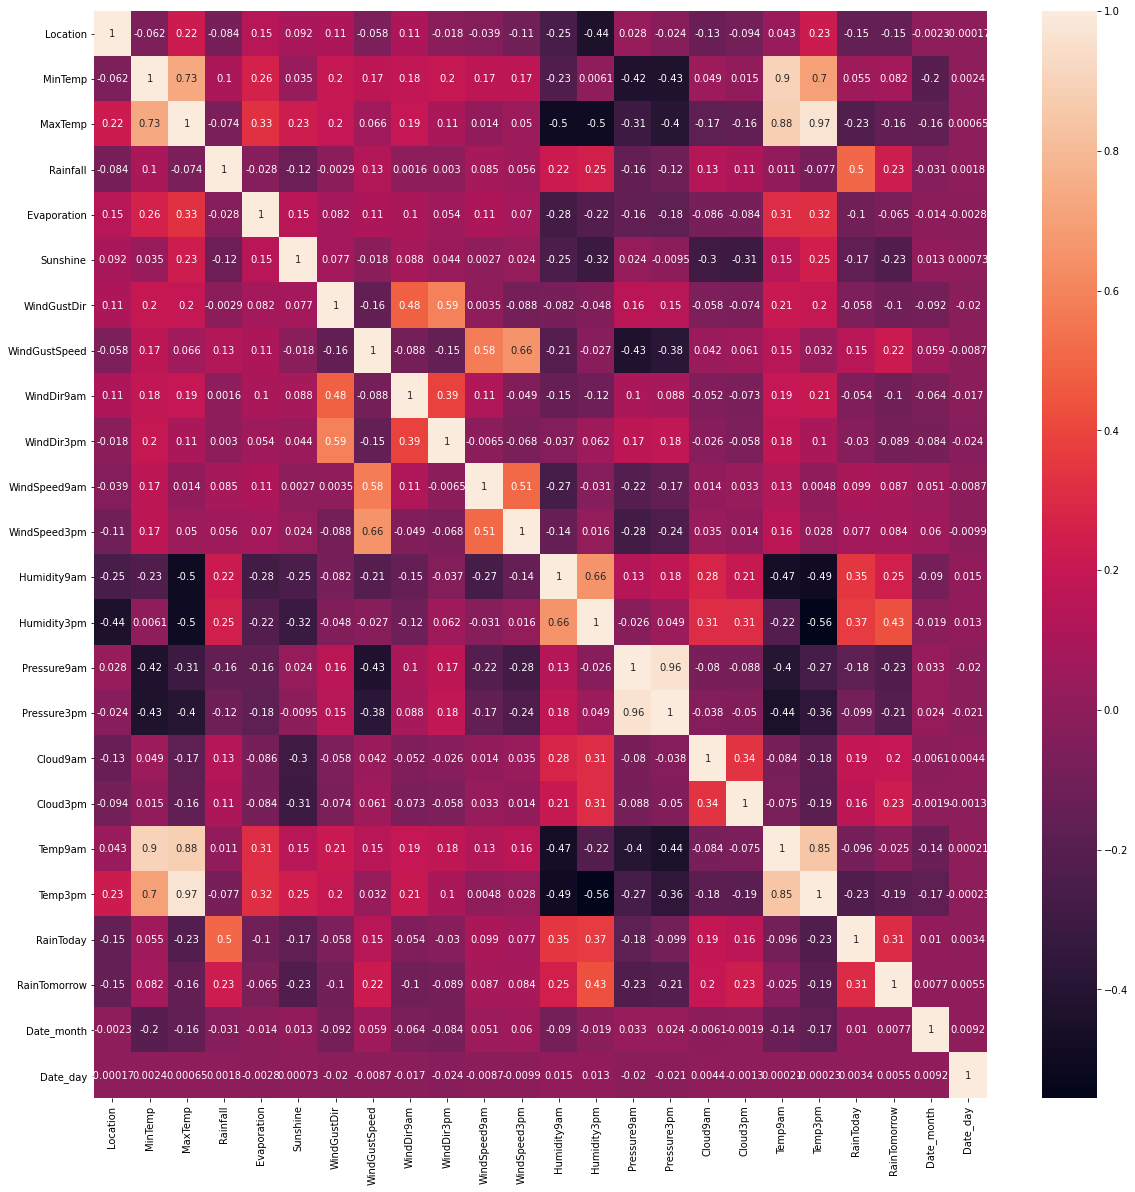

In [27]:
corrmat = df.corr()
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

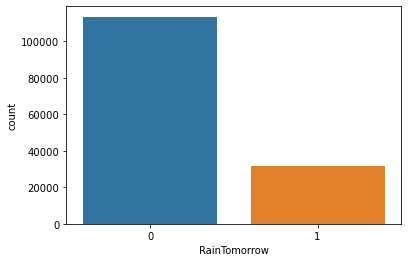

In [28]:
sns.countplot(df["RainTomorrow"])

In [29]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,12,1
1,2008-12-02,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,12,2
2,2008-12-03,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,12,3
3,2008-12-04,30,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,12,4
4,2008-12-05,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,49,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0,6,21
145456,2017-06-22,49,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0,6,22
145457,2017-06-23,49,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0,6,23
145458,2017-06-24,49,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,6,24


In [92]:
df.to_csv('ConvertedweatherAUS.csv')

In [31]:
for feature in continuous_feature:
    print(feature)

MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Temp9am
Temp3pm


Finding anomaly or outlier is known as anomaly detection or outlier detection. The easiest method is Interquartile Range (IQR)

In [32]:
IQR=df.MinTemp.quantile(0.75)-df.MinTemp.quantile(0.25)
lower_bridge=df.MinTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MinTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-5.950000000000002 30.450000000000003


In [33]:
df.loc[df['MinTemp']>=30.45,'MinTemp']=30.45
df.loc[df['MinTemp']<=-5.95,'MinTemp']=-5.95

In [34]:
IQR=df.MaxTemp.quantile(0.75)-df.MaxTemp.quantile(0.25)
lower_bridge=df.MaxTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MaxTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.700000000000001 43.5


In [35]:
df.loc[df['MaxTemp']>=43.5,'MaxTemp']=43.5
df.loc[df['MaxTemp']<=2.7,'MaxTemp']=2.7

In [36]:
IQR=df.Rainfall.quantile(0.75)-df.Rainfall.quantile(0.25)
lower_bridge=df.Rainfall.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Rainfall.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-0.8999999999999999 1.5


In [37]:
df.loc[df['Rainfall']>=1.5,'Rainfall']=1.5
df.loc[df['Rainfall']<=-0.89,'Rainfall']=-0.89

In [38]:
IQR=df.Evaporation.quantile(0.75)-df.Evaporation.quantile(0.25)
lower_bridge=df.Evaporation.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Evaporation.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-4.600000000000001 14.600000000000001


In [39]:
df.loc[df['Evaporation']>=14.6,'Evaporation']=14.6
df.loc[df['Evaporation']<=-4.6,'Evaporation']=-4.6

In [40]:
IQR=df.WindGustSpeed.quantile(0.75)-df.WindGustSpeed.quantile(0.25)
lower_bridge=df.WindGustSpeed.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindGustSpeed.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

8.5 68.5


In [41]:
df.loc[df['WindGustSpeed']>=68.5,'WindGustSpeed']=68.5
df.loc[df['WindGustSpeed']<=8.5,'WindGustSpeed']=8.5

In [42]:
IQR=df.WindSpeed9am.quantile(0.75)-df.WindSpeed9am.quantile(0.25)
lower_bridge=df.WindSpeed9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-11.0 37.0


In [43]:
df.loc[df['WindSpeed9am']>=37,'WindSpeed9am']=37
df.loc[df['WindSpeed9am']<=-11,'WindSpeed9am']=-11

In [44]:
IQR=df.WindSpeed3pm.quantile(0.75)-df.WindSpeed3pm.quantile(0.25)
lower_bridge=df.WindSpeed3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-3.5 40.5


In [45]:
df.loc[df['WindSpeed3pm']>40.5,'WindSpeed3pm']=40.5
df.loc[df['WindSpeed3pm']<=-3.5,'WindSpeed3pm']=-3.5

In [46]:
IQR=df.Humidity9am.quantile(0.75)-df.Humidity9am.quantile(0.25)
lower_bridge=df.Humidity9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Humidity9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

18.0 122.0


In [47]:
df.loc[df['Humidity9am']>=122,'Humidity9am']=122
df.loc[df['Humidity9am']<=18,'Humidity9am']=18

In [48]:
IQR=df.Pressure9am.quantile(0.75)-df.Pressure9am.quantile(0.25)
lower_bridge=df.Pressure9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

1001.0500000000001 1034.25


In [49]:
df.loc[df['Pressure9am']>=1034.25,'Pressure9am']=1034.25
df.loc[df['Pressure9am']<=1001.05,'Pressure9am']=1001.05

In [50]:
IQR=df.Pressure3pm.quantile(0.75)-df.Pressure3pm.quantile(0.25)
lower_bridge=df.Pressure3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

998.6500000000001 1031.85


In [51]:
df.loc[df['Pressure3pm']>=1031.85,'Pressure3pm']=1031.85
df.loc[df['Pressure3pm']<=998.65,'Pressure3pm']=998.65

In [52]:
IQR=df.Temp9am.quantile(0.75)-df.Temp9am.quantile(0.25)
lower_bridge=df.Temp9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-1.4999999999999982 35.3


In [53]:
df.loc[df['Temp9am']>=35.3,'Temp9am']=35.3
df.loc[df['Temp9am']<=-1.49,'Temp9am']=-1.49

In [54]:
IQR=df.Temp3pm.quantile(0.75)-df.Temp3pm.quantile(0.25)
lower_bridge=df.Temp3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.4499999999999993 40.45


In [55]:
df.loc[df['Temp3pm']>=40.45,'Temp3pm']=40.45
df.loc[df['Temp3pm']<=2.45,'Temp3pm']=2.45

In [56]:
X = df.drop(["RainTomorrow", "Date"], axis=1)
Y = df["RainTomorrow"]

In [57]:
# scaler = RobustScaler()
# X_scaled = scaler.fit_transform(X)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size =0.2, stratify = Y, random_state = 0)

In [59]:
y_train

43447     0
140904    0
54615     0
109793    0
74462     0
         ..
106567    0
52791     1
56339     0
82299     1
115175    0
Name: RainTomorrow, Length: 116368, dtype: uint8

In [60]:
X_train.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Date_month,Date_day
43447,20,10.7,18.3,0.0,3.2,10.1,4.0,37.0,6.0,6.0,17.0,15.0,54.0,42.0,1015.9,1014.1,3.0,2.0,13.8,17.9,0,6,19
140904,11,21.2,33.1,0.0,7.2,10.7,3.0,41.0,12.0,5.0,17.0,31.0,67.0,35.0,1016.4,1011.4,1.0,5.0,25.7,31.8,0,8,26
54615,12,15.5,26.1,0.0,2.4,5.6,2.0,59.0,2.0,3.0,19.0,20.0,49.0,30.0,1017.6,1015.2,5.0,1.0,17.5,25.6,0,2,25
109793,7,14.2,17.6,1.5,8.6,7.1,4.0,39.0,6.0,4.0,26.0,9.0,83.0,54.0,1009.2,1009.6,8.0,7.0,15.6,16.2,1,5,6
74462,47,14.4,29.5,0.0,4.0,8.2,10.0,44.0,11.0,10.0,31.0,22.0,68.0,34.0,1016.3,1014.1,0.0,1.0,18.2,27.3,0,1,25


In [61]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [62]:
prediction = rf.predict(X_test)
print(confusion_matrix(y_test,prediction))
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

[[21717  1000]
 [ 3257  3118]]
0.8536711123332875
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     22717
           1       0.76      0.49      0.59      6375

    accuracy                           0.85     29092
   macro avg       0.81      0.72      0.75     29092
weighted avg       0.84      0.85      0.84     29092



In [63]:
np.mean((prediction-y_test)**2)

0.1463288876667125

0.7225390711111227

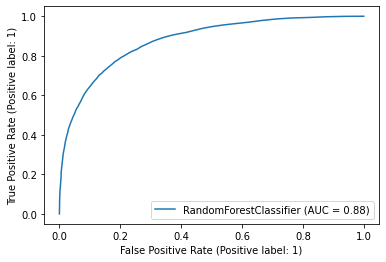

In [64]:
metrics.plot_roc_curve(rf, X_test, y_test)
metrics.roc_auc_score(y_test, prediction, average=None) 

In [65]:
# joblib.dump(rf, "rf.pkl")

In [66]:
#Saving the Model
import pickle
pickle_out = open("rf3.pkl", "wb") 
pickle.dump(rf, pickle_out) 
pickle_out.close()

In [67]:
from sklearn.ensemble import RandomForestRegressor

In [68]:
rf1=RandomForestRegressor(max_depth=10, random_state=0,n_estimators=100)
rf1.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, random_state=0)

In [69]:
prediction1 = rf1.predict(X_test)
np.mean((prediction1-y_test)**2)

0.10901021918868406

In [70]:
joblib.dump(rf1, "rf1.pkl")

['rf1.pkl']

In [71]:
rf2=RandomForestRegressor(max_depth=50, random_state=0,n_estimators=100)
rf2.fit(X_train,y_train)

RandomForestRegressor(max_depth=50, random_state=0)

In [72]:
prediction2 = rf2.predict(X_test)
np.mean((prediction2-y_test)**2)

0.10736219579266575

In [73]:
joblib.dump(rf2, "rf2.pkl")

['rf2.pkl']

In [91]:
data=[float(num) for num in (input("enter the data:").strip().split())]
predictions = rf.predict([data])
print("")
print("------------------------")

if predictions ==0 :
    
    print(colored("Tomorrow will be a : Sunny day",'red',attrs=['bold']))
else:
    print(colored("Tomorrow will be a : Rainy day",'blue',attrs=['bold']))
    

enter the data:30	9.7	31.9	0	3	6.1	0	80	13	0	7	28	42	9	1008.9	1003.6	1	8	18.3	30.2	0	12	9

------------------------
Tomorrow will be a : Sunny day
